# Trump Statistics

## Note that data is imbalanced (truth = 11%)

## Significantly higher for Truth
Statement: Average word length

## Significantly higher for Falsehoods
General POS tagging (15 tags): coordinating conjunction (i.e.,"and", "but", "or" etc.), possessive, and space

Specific POS tagging (52 tags): adverbs, coordinating conjunction, existential there, infinitival to, personal pronoun, punctuation marks (periods), quotation marks (opening), paranthesis, spaces, verb (base form, non-3rd person singular present, past tense), wh-determine and wh-pronoun (personal).

NER: references to organizations and percentages

SD: 'attribute', 'auxiliary', 'auxiliary (passive)',
       'coordinating conjunction', 'clausal complement', 'conjunct', 'dative',
       'unclassified dependent', 'determiner', 'expletive', 'nominal subject',
       'nominal subject (passive)', 'object predicate', 'particle',
       'relative clause modifier', 'open clausal complement'

# Summary

## Lemmatized Statements for Machine Learning
Lemmatized Statements (removed whitespaces, puncuation, stopwords, special characters; converted to lowercase)

## Tagged Statements
POS (part of speech): Is this word an adjective, noun, something else?

NER (named entity recognition tagging): tags the kind of noun--person, place, organization, etc.--among other things

SD (syntatic dependency): the relation between tokens

## Features Engineered from Statements
No. of characters

No. of words

Avg. length of words

Readability score

In [1]:
# import packages not on my computer through jupyter notebooks

# import sys
# !{sys.executable} -m pip install textatistic
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download en_core_web_sm # doesn't include word vectors
# !{sys.executable} -m spacy download en_core_web_md # includes word vectors

In [2]:
# for Data Manipulation
import pandas as pd
import numpy as np
import os
import csv 

# for EDA
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline   
from collections import Counter

# for NLP
from textatistic import Textatistic
import spacy
from spacy import displacy

# for Statistics
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [3]:
# Use cleaner absolute path to find file
path = os.path.abspath('politifact_trump_data.csv')
df = pd.read_csv(path, index_col=0)

# to see statement in full
pd.set_option('display.max_colwidth', 200) 

# See sample of data
df.head(3)

,statement,source,link,veracity,freq
35,"""The Kurds are much safer right now.""",Donald Trump,/truth-o-meter/statements/2019/oct/16/donald-trump/after-attacks-turkey-trump-falsely-claims-kurds-sy/,False,181
58,"""Fact: Joe Biden pressured Ukraine to fire its prosecutor .... Fact: the prosecutor said he was forced out for leading a corruption probe into Hunter Biden's company. Fact: Democrats want to impea...",Donald Trump,/truth-o-meter/statements/2019/oct/11/donald-trump/trump-ad-misleads-about-biden-ukraine-and-prosecut/,False,181
66,"""The first so-called second hand information ‘Whistleblower’ got my phone conversation almost completely wrong.""",Donald Trump,/truth-o-meter/statements/2019/oct/09/donald-trump/donald-trump-whistleblower-got-phone-call-almost-c/,Pants on Fire!,181


# Dataframe column label explanations
date = date statement was made

source = source of statement

freq = frequency which source occurs in dataframe

statement = the statement which was evaluated for veracity at https://www.politifact.com

veracity = the truthfulness of a statement

In [4]:
df.veracity.value_counts()

False             121
Pants on Fire!     42
True               18
Name: veracity, dtype: int64

# data is imbalanced! (only 11% truth)

# Preprocessing Steps: Creating a condensed (lemmatized) text
Start: Original Text

1) Lowercasing: Examples -> examples

2) Reduction to root form: examples -> example

End: Lemmatized Text

# Other Text Preprocessing Techniques
removing whitespaces, punctuation, stopwords, special characters (numbers, etc.), html/xml tags

expanding contractions (may not be needed if stopwords removed since contracted words are typically stopwords)

replacing accented characters

correcting spelling errors

In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
# lemmatization function
def lemmatize(text):
    # create nlp object
    nobj = nlp(text)
    
    # stopword list from spacy
    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    
    # simple lemmas
    lemmas = [token.lemma_ for token in nobj]
    
    # lowercase; remove non-alphabetic characters & overly used words, i.e., stop words
    a_lemmas = [lemma.lower() for lemma in lemmas
                if lemma.isalpha() 
                and lemma not in stopwords]
    
    # strings
    strings = " ".join(a_lemmas)
    
    return strings

In [8]:
df["lemmas"] = df.statement.apply(lemmatize)

# Tagging Text
POS (parts of speech; POS Tagging): Is this word an adjective, noun, something else?

NER (named entity recognition tagging; tags the kind of noun--person, place, organization, etc.--among other things)

SD (syntatic dependency): the relation between tokens

# Part of Speech (POS) Tagging

## .pos_ (general pos tagging -- 15 tags)
#### .pos_ tags are based on the Google Universal POS Tags (spaCy extends the list)

In [9]:
def dot_pos_tagger(text):
    # nlp object
    nobj = nlp(text)
    # POS tags
    tagged_text = [(token.text, token.pos_) for token in nobj]
    # tagged text
    return tagged_text

df["general_pos_tags"] = df.statement.apply(dot_pos_tagger)

## .tag_ (specific pos tagging -- 52 tags)
#### .tag_ uses OntoNotes 5 from the Penn Treebank tag set

In [11]:
def dot_tag_tagger(text):
    # nlp object
    nobj = nlp(text)
    # tags
    tagged_text = [(token.text, token.tag_) for token in nobj]
    # tagged text
    return tagged_text

df["specific_pos_tags"] = df.statement.apply(dot_tag_tagger)

# NER (named-entity recognition) tagging

In [13]:
# ner function
def ner_tagger(text):
    # nlp object
    nobj = nlp(text)
    # ner tags
    ne = [(ent.text, ent.label_) for ent in nobj.ents]
    return ne

In [14]:
df["ner_tags"] = df.statement.apply(ner_tagger)

# SD (Syntatic Dependency) tagging

In [16]:
# sd function
def sd_tagger(text):
    # nlp object
    nobj = nlp(text)
    # tags
    tagged_text = [(token.text, token.dep_) for token in nobj]
    # tagged text
    return tagged_text

df["sd_tags"] = df.statement.apply(sd_tagger)

# Feature Engineering from the original text and its lemma version
No. of characters

No. of words

Avg. length of words

In [18]:
# no. of characters
df["statement_char_count"] = df.statement.apply(len)

In [19]:
# no. of words function
def word_counter(text):
    
    # split text by blank spaces
    words = text.split()
    
    # count words
    return len(words)

In [20]:
# no. of words
df["statement_word_count"] = df.statement.apply(word_counter)

In [21]:
# avg. word length function
def avg_word_length(text):
    
    # split text into words
    words = text.split()
    
    # length of each word
    word_lengths = [len(w) for w in words] 
    
    # avg length
    avg_length = sum(word_lengths)/len(word_lengths)     
    return round((avg_length),1)

In [22]:
# avg. word length
df["statement_avg_word_len"] = df.statement.apply(avg_word_length)

# statistics

In [24]:
# func for comparing truth vs lie
def tvsf(column_label):
    
    # t & f variables
    truths = df[df['veracity'] == 'True'][column_label]
    falsehoods = df[df['veracity'] == 'False'][column_label]
    
    # means
    truths_mean = round(truths.mean(), 1)
    falsehoods_mean = round(falsehoods.mean(), 1)
    
    # t-test
    t,p = stats.ttest_ind(truths,
                          falsehoods, 
                          equal_var = False)
    if p <= 0.05:
        print("!!! SIGNIFICANT !!!")
        print(column_label, "p-value:", "{:.3f}".format(p))
    else:
        print("-Not Sgnfcnt-")
        print(column_label, "p-value:", "{:.3f}".format(p))
    print("T Avg.", column_label, ":", truths_mean)
    print("F Avg.", column_label, ":", falsehoods_mean)

In [25]:
tvsf("statement_char_count")

-Not Sgnfcnt-
statement_char_count p-value: 0.513
T Avg. statement_char_count : 98.4
F Avg. statement_char_count : 105.9


In [26]:
tvsf("statement_word_count")

-Not Sgnfcnt-
statement_word_count p-value: 0.150
T Avg. statement_word_count : 15.4
F Avg. statement_word_count : 18.3


In [27]:
tvsf("statement_avg_word_len")

!!! SIGNIFICANT !!!
statement_avg_word_len p-value: 0.003
T Avg. statement_avg_word_len : 5.6
F Avg. statement_avg_word_len : 5.0


#### Average word length is statistically higher for Truths
#### Interpretation: When Trump uses bigger words he has a higher chance of being honest

# lemma statistics

In [28]:
# with try and except
# b/c some lemmas do not contain words
def try_avg_word_len(text):
    try:
        return round(avg_word_length(text),1)
    except ZeroDivisionError:
        return -1

df["lemma_char_count"] = df.lemmas.apply(len)
df["lemma_word_count"] = df.lemmas.apply(word_counter)
df["lemma_avg_word_len"] = df.lemmas.apply(try_avg_word_len)

In [29]:
df.head(2)

,statement,source,link,veracity,freq,lemmas,general_pos_tags,specific_pos_tags,ner_tags,sd_tags,statement_char_count,statement_word_count,statement_avg_word_len,lemma_char_count,lemma_word_count,lemma_avg_word_len
35,"""The Kurds are much safer right now.""",Donald Trump,/truth-o-meter/statements/2019/oct/16/donald-trump/after-attacks-turkey-trump-falsely-claims-kurds-sy/,False,181,kurds safe right,"[("", PUNCT), (The, DET), (Kurds, PROPN), (are, AUX), (much, ADV), (safer, ADJ), (right, ADV), (now, ADV), (., PUNCT), ("", PUNCT)]","[("", ``), (The, DT), (Kurds, NNPS), (are, VBP), (much, RB), (safer, JJR), (right, RB), (now, RB), (., .), ("", '')]","[(Kurds, NORP)]","[("", punct), (The, det), (Kurds, nsubj), (are, ROOT), (much, advmod), (safer, acomp), (right, advmod), (now, advmod), (., punct), ("", punct)]",37,7,4.4,16,3,4.7
58,"""Fact: Joe Biden pressured Ukraine to fire its prosecutor .... Fact: the prosecutor said he was forced out for leading a corruption probe into Hunter Biden's company. Fact: Democrats want to impea...",Donald Trump,/truth-o-meter/statements/2019/oct/11/donald-trump/trump-ad-misleads-about-biden-ukraine-and-prosecut/,False,181,fact joe biden pressure ukraine fire prosecutor fact prosecutor force lead corruption probe hunter biden company fact democrats want impeach president trump discuss investigation ukraine president,"[("", PUNCT), (Fact, NOUN), (:, PUNCT), (Joe, PROPN), (Biden, PROPN), (pressured, VERB), (Ukraine, PROPN), (to, PART), (fire, VERB), (its, PRON), (prosecutor, NOUN), (...., PUNCT), (Fact, NOUN), (:...","[("", ``), (Fact, NN), (:, :), (Joe, NNP), (Biden, NNP), (pressured, VBD), (Ukraine, NNP), (to, TO), (fire, VB), (its, PRP$), (prosecutor, NN), (...., .), (Fact, NN), (:, :), (the, DT), (prosecutor...","[(Joe Biden, PERSON), (Ukraine, GPE), (Hunter Biden's, PERSON), (Democrats, NORP), (Trump, PERSON), (Ukraine, GPE)]","[("", punct), (Fact, ROOT), (:, punct), (Joe, compound), (Biden, nsubj), (pressured, acl), (Ukraine, dobj), (to, aux), (fire, xcomp), (its, poss), (prosecutor, dobj), (...., punct), (Fact, dep), (:...",275,41,5.7,196,26,6.6


In [30]:
tvsf("lemma_char_count")
print("")
tvsf("lemma_word_count")
print("")
tvsf("lemma_avg_word_len")

-Not Sgnfcnt-
lemma_char_count p-value: 0.526
T Avg. lemma_char_count : 59.7
F Avg. lemma_char_count : 55.1

-Not Sgnfcnt-
lemma_word_count p-value: 0.686
T Avg. lemma_word_count : 8.4
F Avg. lemma_word_count : 8.0

-Not Sgnfcnt-
lemma_avg_word_len p-value: 0.345
T Avg. lemma_avg_word_len : 6.3
F Avg. lemma_avg_word_len : 6.1


### With lemmatization, statements lose significant differences in terms of length, etc.

# More Features that can be engineered
No. of sentences

No. of paragraphs

Words starting with an uppercase

All-capital words

Numeric quantities

Readability Score

# Readability Tests

In [31]:
# readability func
def readability(text):    
    # scores
    readability_scores = Textatistic(text).scores
    """ 
    Gunningfog Score depends on sentence length and syllable amount
    17 = College Graduate
    ...
    6 = 6th grade
    """
    gunningfog_score = readability_scores["gunningfog_score"]
    return gunningfog_score

# with try and except
# b/c some sentences do not end with a period
def readability_try(text):
    try:
        return round(readability(text),1)
    except ZeroDivisionError:
        return -1

In [32]:
# readability scores
df["read_score_gun"] = df.statement.apply(readability_try)

In [34]:
tvsf("read_score_gun")

-Not Sgnfcnt-
read_score_gun p-value: 0.093
T Avg. read_score_gun : 10.1
F Avg. read_score_gun : 7.8


#### reading score (i.e., sentence length and syllable count) appears loosely (p = 0.093) tied to truths

next, we should also examine if certain kinds of words appear more often in falsehoods than in truths like adjectives or nouns

# POS dictionaries and lists for statistics

### .pos_ tag's dictionary and list

In [87]:
# first we need a dictionary and list of all the possible tags
# csv made from https://spacy.io/api/annotation#pos-tagging
# here's a df of all .pos_ tags for ease of readabilty
path = os.path.abspath('pos.csv')
dot_pos_df = pd.read_csv(path)
dot_pos_df[["POS","description"]]

,POS,description
0,ADJ,adjective
1,ADP,conjunction or particle or adverb
2,ADV,adverb
3,CCONJ,coordinating conjuction
4,DET,determiner
5,INTJ,interjection
6,NOUN,noun
7,NUM,number
8,PART,possessive
9,PRON,pronoun


In [36]:
# .pos_ tags in dictionary form
with open('pos.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('pos_dict.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict_pos = {rows[0]:rows[1] for rows in reader}

In [37]:
# preview dictionary
list(mydict_pos.items())[0:3]

[('POS', 'description'),
 ('ADJ', 'adjective'),
 ('ADP', 'conjunction or particle or adverb')]

In [38]:
# delete first entry in dict, i.e., column labels
del mydict_pos["POS"]

In [39]:
# we'll use this to automate later tasks
dot_pos_list = list(mydict_pos.keys())
print(dot_pos_list[0:3])

['ADJ', 'ADP', 'ADV']


### .tag_ tag's dictionary and list

In [40]:
# df of all .tag_ tags for ease of readabilty
# csv made from https://spacy.io/api/annotation#pos-tagging
path = os.path.abspath('tags.csv')
dot_tag_df = pd.read_csv(path)
dot_tag_df[["tag","description"]][0:2]

,tag,description
0,GW,additional word in multi-word expression
1,JJ,adjective


In [41]:
# .tag_ in dictionary form
with open('tags.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('tags_dict.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict_tag = {rows[0]:rows[1] for rows in reader}

In [42]:
list(mydict_tag.items())[8:11]

[('RBS', 'adverb (superlative)'), ('AFX', 'affix'), ('CD', 'cardinal number')]

In [43]:
# delete first entry in dict, i.e., column labels
del mydict_tag["tag"]

In [44]:
# we'll use this to automate later tasks
dot_tag_list = list(mydict_tag.keys())
print(dot_tag_list[8:12])

['AFX', 'CD', 'CC', 'IN']


# Automating POS tag counts

In [45]:
def dot_pos_counter(text, p):
    # nlp object
    nobj = nlp(text)
    # list of POS tags
    pos = [token.pos_ for token in nobj]
    # count POS
    return pos.count(p)

In [46]:
# loop through the list of .pos_ tags and create new columns with counts for each tag
# this takes several minutes
for p in dot_pos_list:
    # df[p] = df.statement.apply(lambda x : proper_nouns(x, p)) #this works; check if below works in 2nd run
    df[("pos_"+mydict_pos[p])] = df.statement.apply(lambda x : dot_pos_counter(x, p))

In [47]:
def dot_tag_counter(text, t):
    # nlp object
    nobj = nlp(text)
    # list of tags
    tg = [token.tag_ for token in nobj]
    # count
    return tg.count(t)

In [48]:
# loop through the list of .tag_ tags and create new columns with counts for each tag
# this takes several minutes
for t in dot_tag_list:
    # df[p] = df.statement.apply(lambda x : proper_nouns(x, p)) #this works; check if below works in 2nd run
    df[("tag_"+mydict_tag[t])] = df.statement.apply(lambda x : dot_tag_counter(x, t))

In [86]:
df.head(1)

,statement,source,link,veracity,freq,lemmas,general_pos_tags,specific_pos_tags,ner_tags,sd_tags,statement_char_count,statement_word_count,statement_avg_word_len,lemma_char_count,lemma_word_count,lemma_avg_word_len,read_score_gun,pos_adjective,pos_conjunction or particle or adverb,pos_adverb,pos_coordinating conjuction,pos_determiner,pos_interjection,pos_noun,pos_number,pos_possessive,pos_pronoun,pos_proper noun,pos_punctuation,pos_space,pos_symbol,pos_verb,pos_unknown,tag_additional word in multi-word expression,tag_adjective,tag_adjective (comparative),tag_adjective (superlative),tag_adverb,tag_adverb (comparative),tag_adverb (particle),tag_adverb (superlative),tag_affix,tag_cardinal number,tag_conjunction (coordinating),tag_conjunction (subordinating or preposition),tag_determiner,tag_email,tag_existential there,tag_foreign word,tag_infinitival “to”,tag_interjection,tag_list item marker,tag_missing tag,tag_noun (plural),tag_noun (proper plural),tag_noun (proper singular),tag_noun (singular or mass),tag_possessive ending,tag_predeterminer,tag_pronoun (personal),tag_pronoun (possessive),tag_punctuation mark (colon or ellipsis),tag_punctuation mark (comma),tag_punctuation mark (hyphen),tag_punctuation mark (sentence closer),tag_quotation mark (closing),tag_quotation mark (opening),tag_round bracket (left),tag_round bracket (right),tag_space_01,tag_space_02,tag_superfluous punctuation,tag_symbol,tag_symbol (currency),tag_unknown,tag_verb (3rd person singular present),tag_verb (base form),tag_verb (gerund or present participle),tag_verb (modal or auxiliary),tag_verb (non-3rd person singular present),tag_verb (past participle),tag_verb (past tense),tag_wh-adverb,tag_wh-determiner,tag_wh-pronoun (personal),tag_wh-pronoun (possessive),ner_people,ner_groups,ner_facilities,ner_organizations,ner_regions,ner_landmarks,ner_products,ner_events,ner_art,ner_laws,ner_languages,ner_dates,ner_times,ner_percentages,ner_money,ner_quantity,ner_ordinality,ner_numerals,sd_clausal modifier of noun (adjectival clause),sd_adjectival complement,sd_adverbial clause modifier,sd_adverbial modifier,sd_agent,sd_adjectival modifier,sd_appositional modifier,sd_attribute,sd_auxiliary,sd_auxiliary (passive),sd_case marking,sd_coordinating conjunction,sd_clausal complement,sd_compound,sd_conjunct,sd_copula,sd_clausal subject,sd_clausal subject (passive),sd_dative,sd_unclassified dependent,sd_determiner,sd_direct object,sd_expletive,sd_interjection,sd_marker,sd_meta modifier,sd_negation modifier,sd_noun compound modifier,sd_modifier of nominal,sd_noun phrase as adverbial modifier,sd_nominal subject,sd_nominal subject (passive),sd_numeric modifier,sd_object predicate,sd_object,sd_oblique nominal,sd_parataxis,sd_complement of preposition,sd_object of preposition,sd_possession modifier,sd_pre-correlative conjunction,sd_prepositional modifier,sd_particle,sd_punctuation,sd_modifier of quantifier,sd_relative clause modifier,sd_root,sd_open clausal complement
35,"""The Kurds are much safer right now.""",Donald Trump,/truth-o-meter/statements/2019/oct/16/donald-trump/after-attacks-turkey-trump-falsely-claims-kurds-sy/,False,181,kurds safe right,"[("", PUNCT), (The, DET), (Kurds, PROPN), (are, AUX), (much, ADV), (safer, ADJ), (right, ADV), (now, ADV), (., PUNCT), ("", PUNCT)]","[("", ``), (The, DT), (Kurds, NNPS), (are, VBP), (much, RB), (safer, JJR), (right, RB), (now, RB), (., .), ("", '')]","[(Kurds, NORP)]","[("", punct), (The, det), (Kurds, nsubj), (are, ROOT), (much, advmod), (safer, acomp), (right, advmod), (now, advmod), (., punct), ("", punct)]",37,7,4.4,16,3,4.7,2.8,1,0,3,0,1,0,0,0,0,0,1,3,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0


# POS Statistics

### .pos_

In [50]:
""" 
since the tvsf function output would be difficult to read, let's convert to a dataframe output
"""

# func for comparing truth vs lie
def df_tvsf(tag_type, column_dict, index_list):
    #ex: df_tvsf("pos_", mydict_pos, dot_pos_list)
    
    d = []
    for x in index_list:
        
        # t & f variables
        truths = df[df['veracity'] == 'True'][tag_type+column_dict[x]]
        falsehoods = df[df['veracity'] == 'False'][tag_type+column_dict[x]]

        # means
        truths_mean = round(truths.mean(), 2)
        falsehoods_mean = round(falsehoods.mean(), 2)

        # t-test
        t,p = stats.ttest_ind(truths,
                              falsehoods, 
                              equal_var = False)
        # dataframe
        d.append({'t_means' : truths_mean, 
                  'f_means' : falsehoods_mean, 
                  'p_value' : round(p,3)})
        
    return pd.DataFrame(d, index = column_dict.values())[['t_means', 'f_means', 'p_value']]

In [84]:
# return df with probability values that approach or are significant
dot_pos_df = df_tvsf("pos_", mydict_pos, dot_pos_list)
dot_pos_df[dot_pos_df.p_value < 0.05]

,t_means,f_means,p_value
coordinating conjuction,0.17,0.42,0.028
possessive,0.11,0.60,0.000
space,0.00,0.06,0.008


# significantly more likely in falsehoods: 
### coordinating conjunction (i.e.,"and", "but", "or" etc.), possessive, and space

In [100]:
df[df["pos_space"] > 0].head(3)

,statement,source,link,veracity,freq,lemmas,general_pos_tags,specific_pos_tags,ner_tags,sd_tags,statement_char_count,statement_word_count,statement_avg_word_len,lemma_char_count,lemma_word_count,lemma_avg_word_len,read_score_gun,pos_adjective,pos_conjunction or particle or adverb,pos_adverb,pos_coordinating conjuction,pos_determiner,pos_interjection,pos_noun,pos_number,pos_possessive,pos_pronoun,pos_proper noun,pos_punctuation,pos_space,pos_symbol,pos_verb,pos_unknown,tag_additional word in multi-word expression,tag_adjective,tag_adjective (comparative),tag_adjective (superlative),tag_adverb,tag_adverb (comparative),tag_adverb (particle),tag_adverb (superlative),tag_affix,tag_cardinal number,tag_conjunction (coordinating),tag_conjunction (subordinating or preposition),tag_determiner,tag_email,tag_existential there,tag_foreign word,tag_infinitival “to”,tag_interjection,tag_list item marker,tag_missing tag,tag_noun (plural),tag_noun (proper plural),tag_noun (proper singular),tag_noun (singular or mass),tag_possessive ending,tag_predeterminer,tag_pronoun (personal),tag_pronoun (possessive),tag_punctuation mark (colon or ellipsis),tag_punctuation mark (comma),tag_punctuation mark (hyphen),tag_punctuation mark (sentence closer),tag_quotation mark (closing),tag_quotation mark (opening),tag_round bracket (left),tag_round bracket (right),tag_space_01,tag_space_02,tag_superfluous punctuation,tag_symbol,tag_symbol (currency),tag_unknown,tag_verb (3rd person singular present),tag_verb (base form),tag_verb (gerund or present participle),tag_verb (modal or auxiliary),tag_verb (non-3rd person singular present),tag_verb (past participle),tag_verb (past tense),tag_wh-adverb,tag_wh-determiner,tag_wh-pronoun (personal),tag_wh-pronoun (possessive),ner_people,ner_groups,ner_facilities,ner_organizations,ner_regions,ner_landmarks,ner_products,ner_events,ner_art,ner_laws,ner_languages,ner_dates,ner_times,ner_percentages,ner_money,ner_quantity,ner_ordinality,ner_numerals,sd_clausal modifier of noun (adjectival clause),sd_adjectival complement,sd_adverbial clause modifier,sd_adverbial modifier,sd_agent,sd_adjectival modifier,sd_appositional modifier,sd_attribute,sd_auxiliary,sd_auxiliary (passive),sd_case marking,sd_coordinating conjunction,sd_clausal complement,sd_compound,sd_conjunct,sd_copula,sd_clausal subject,sd_clausal subject (passive),sd_dative,sd_unclassified dependent,sd_determiner,sd_direct object,sd_expletive,sd_interjection,sd_marker,sd_meta modifier,sd_negation modifier,sd_noun compound modifier,sd_modifier of nominal,sd_noun phrase as adverbial modifier,sd_nominal subject,sd_nominal subject (passive),sd_numeric modifier,sd_object predicate,sd_object,sd_oblique nominal,sd_parataxis,sd_complement of preposition,sd_object of preposition,sd_possession modifier,sd_pre-correlative conjunction,sd_prepositional modifier,sd_particle,sd_punctuation,sd_modifier of quantifier,sd_relative clause modifier,sd_root,sd_open clausal complement
343,"""Mexico, they took 30% of our automobile business.""",Donald Trump,/wisconsin/statements/2019/jul/23/donald-trump/no-mexico-didnt-take-30-us-auto-business-trump-cla/,False,181,mexico automobile business,"[("", PUNCT), (Mexico, PROPN), (,, PUNCT), (they, PRON), (took, VERB), (30, NUM), (%, NOUN), ( , SPACE), (of, ADP), (our, PRON), (automobile, NOUN), (business, NOUN), (., PUNCT), ("", PUNCT)]","[("", ``), (Mexico, NNP), (,, ,), (they, PRP), (took, VBD), (30, CD), (%, NN), ( , _SP), (of, IN), (our, PRP$), (automobile, NN), (business, NN), (., .), ("", '')]","[(Mexico, GPE), (30%, PERCENT)]","[("", punct), (Mexico, npadvmod), (,, punct), (they, nsubj), (took, ROOT), (30, nummod), (%, dobj), ( , ), (of, prep), (our, poss), (automobile, compound), (business, pobj), (., punct), ("", punct)]",51,8,5.5,26,3,8.0,8.2,0,1,0,0,0,0,3,1,0,2,1,4,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,3,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

### .tag_

In [101]:
# return df with probability values that approach or are significant
dot_tag_df = df_tvsf("tag_", mydict_tag, dot_tag_list)
dot_tag_df[dot_tag_df.p_value < 0.05]

,t_means,f_means,p_value
adverb (particle),0.00,0.17,0.000
adverb (superlative),0.00,0.06,0.008
conjunction (coordinating),0.17,0.42,0.028
existential there,0.00,0.03,0.045
infinitival “to”,0.00,0.30,0.000
pronoun (personal),0.72,1.38,0.048
punctuation mark (sentence closer),1.11,1.46,0.002
quotation mark (opening),1.00,1.05,0.014
round bracket (left),0.00,0.14,0.000
round bracket (right),0.00,0.15,0.000


# significantly more likely in falsehoods: 
### adverbs, coordinating conjunction, existential there, infinitival to, personal pronoun, punctuation marks (periods), quotation marks (opening), paranthesis, spaces, verb (base form, non-3rd person singular present, past tense), wh-determine and wh-pronoun (personal)  

In [105]:
df[df["tag_quotation mark (opening)"] > 2].head(3)

,statement,source,link,veracity,freq,lemmas,general_pos_tags,specific_pos_tags,ner_tags,sd_tags,statement_char_count,statement_word_count,statement_avg_word_len,lemma_char_count,lemma_word_count,lemma_avg_word_len,read_score_gun,pos_adjective,pos_conjunction or particle or adverb,pos_adverb,pos_coordinating conjuction,pos_determiner,pos_interjection,pos_noun,pos_number,pos_possessive,pos_pronoun,pos_proper noun,pos_punctuation,pos_space,pos_symbol,pos_verb,pos_unknown,tag_additional word in multi-word expression,tag_adjective,tag_adjective (comparative),tag_adjective (superlative),tag_adverb,tag_adverb (comparative),tag_adverb (particle),tag_adverb (superlative),tag_affix,tag_cardinal number,tag_conjunction (coordinating),tag_conjunction (subordinating or preposition),tag_determiner,tag_email,tag_existential there,tag_foreign word,tag_infinitival “to”,tag_interjection,tag_list item marker,tag_missing tag,tag_noun (plural),tag_noun (proper plural),tag_noun (proper singular),tag_noun (singular or mass),tag_possessive ending,tag_predeterminer,tag_pronoun (personal),tag_pronoun (possessive),tag_punctuation mark (colon or ellipsis),tag_punctuation mark (comma),tag_punctuation mark (hyphen),tag_punctuation mark (sentence closer),tag_quotation mark (closing),tag_quotation mark (opening),tag_round bracket (left),tag_round bracket (right),tag_space_01,tag_space_02,tag_superfluous punctuation,tag_symbol,tag_symbol (currency),tag_unknown,tag_verb (3rd person singular present),tag_verb (base form),tag_verb (gerund or present participle),tag_verb (modal or auxiliary),tag_verb (non-3rd person singular present),tag_verb (past participle),tag_verb (past tense),tag_wh-adverb,tag_wh-determiner,tag_wh-pronoun (personal),tag_wh-pronoun (possessive),ner_people,ner_groups,ner_facilities,ner_organizations,ner_regions,ner_landmarks,ner_products,ner_events,ner_art,ner_laws,ner_languages,ner_dates,ner_times,ner_percentages,ner_money,ner_quantity,ner_ordinality,ner_numerals,sd_clausal modifier of noun (adjectival clause),sd_adjectival complement,sd_adverbial clause modifier,sd_adverbial modifier,sd_agent,sd_adjectival modifier,sd_appositional modifier,sd_attribute,sd_auxiliary,sd_auxiliary (passive),sd_case marking,sd_coordinating conjunction,sd_clausal complement,sd_compound,sd_conjunct,sd_copula,sd_clausal subject,sd_clausal subject (passive),sd_dative,sd_unclassified dependent,sd_determiner,sd_direct object,sd_expletive,sd_interjection,sd_marker,sd_meta modifier,sd_negation modifier,sd_noun compound modifier,sd_modifier of nominal,sd_noun phrase as adverbial modifier,sd_nominal subject,sd_nominal subject (passive),sd_numeric modifier,sd_object predicate,sd_object,sd_oblique nominal,sd_parataxis,sd_complement of preposition,sd_object of preposition,sd_possession modifier,sd_pre-correlative conjunction,sd_prepositional modifier,sd_particle,sd_punctuation,sd_modifier of quantifier,sd_relative clause modifier,sd_root,sd_open clausal complement
1954,"""The Failing @nytimes quotes ‘a senior White House official,’ who doesn’t exist, as saying ‘even if the meeting were reinstated, holding it on June 12 would be impossible, given the lack of time a...",Donald Trump,/truth-o-meter/statements/2018/may/29/donald-trump/donald-trump-said-ny-times-source-didnt-exist-he-d/,Pants on Fire!,181,failing quote senior white house official exist meeting reinstate hold june impossible lack time planning need wrong use real people phony source,"[("", PUNCT), (The, DET), (Failing, PROPN), (@nytimes, PROPN), (quotes, VERB), (‘, PUNCT), (a, DET), (senior, ADJ), (White, PROPN), (House, PROPN), (official, NOUN), (,, PUNCT), (’, PUNCT), (who, P...","[("", ``), (The, DT), (Failing, NNP), (@nytimes, NNP), (quotes, VBZ), (‘, ``), (a, DT), (senior, JJ), (White, NNP), (House, NNP), (official, NN), (,, ,), (’, ''), (who, WP), (does, VBZ), (n’t, RB),...","[(White House, ORG), (June 12, DATE)]","[("", punct), (The, det), (Failing, amod), (@nytimes, nsubj), (quotes, ROOT), (‘, punct), (a, 

In [108]:
df[df["tag_round bracket (left)"] > 0].head(3)

,statement,source,link,veracity,freq,lemmas,general_pos_tags,specific_pos_tags,ner_tags,sd_tags,statement_char_count,statement_word_count,statement_avg_word_len,lemma_char_count,lemma_word_count,lemma_avg_word_len,read_score_gun,pos_adjective,pos_conjunction or particle or adverb,pos_adverb,pos_coordinating conjuction,pos_determiner,pos_interjection,pos_noun,pos_number,pos_possessive,pos_pronoun,pos_proper noun,pos_punctuation,pos_space,pos_symbol,pos_verb,pos_unknown,tag_additional word in multi-word expression,tag_adjective,tag_adjective (comparative),tag_adjective (superlative),tag_adverb,tag_adverb (comparative),tag_adverb (particle),tag_adverb (superlative),tag_affix,tag_cardinal number,tag_conjunction (coordinating),tag_conjunction (subordinating or preposition),tag_determiner,tag_email,tag_existential there,tag_foreign word,tag_infinitival “to”,tag_interjection,tag_list item marker,tag_missing tag,tag_noun (plural),tag_noun (proper plural),tag_noun (proper singular),tag_noun (singular or mass),tag_possessive ending,tag_predeterminer,tag_pronoun (personal),tag_pronoun (possessive),tag_punctuation mark (colon or ellipsis),tag_punctuation mark (comma),tag_punctuation mark (hyphen),tag_punctuation mark (sentence closer),tag_quotation mark (closing),tag_quotation mark (opening),tag_round bracket (left),tag_round bracket (right),tag_space_01,tag_space_02,tag_superfluous punctuation,tag_symbol,tag_symbol (currency),tag_unknown,tag_verb (3rd person singular present),tag_verb (base form),tag_verb (gerund or present participle),tag_verb (modal or auxiliary),tag_verb (non-3rd person singular present),tag_verb (past participle),tag_verb (past tense),tag_wh-adverb,tag_wh-determiner,tag_wh-pronoun (personal),tag_wh-pronoun (possessive),ner_people,ner_groups,ner_facilities,ner_organizations,ner_regions,ner_landmarks,ner_products,ner_events,ner_art,ner_laws,ner_languages,ner_dates,ner_times,ner_percentages,ner_money,ner_quantity,ner_ordinality,ner_numerals,sd_clausal modifier of noun (adjectival clause),sd_adjectival complement,sd_adverbial clause modifier,sd_adverbial modifier,sd_agent,sd_adjectival modifier,sd_appositional modifier,sd_attribute,sd_auxiliary,sd_auxiliary (passive),sd_case marking,sd_coordinating conjunction,sd_clausal complement,sd_compound,sd_conjunct,sd_copula,sd_clausal subject,sd_clausal subject (passive),sd_dative,sd_unclassified dependent,sd_determiner,sd_direct object,sd_expletive,sd_interjection,sd_marker,sd_meta modifier,sd_negation modifier,sd_noun compound modifier,sd_modifier of nominal,sd_noun phrase as adverbial modifier,sd_nominal subject,sd_nominal subject (passive),sd_numeric modifier,sd_object predicate,sd_object,sd_oblique nominal,sd_parataxis,sd_complement of preposition,sd_object of preposition,sd_possession modifier,sd_pre-correlative conjunction,sd_prepositional modifier,sd_particle,sd_punctuation,sd_modifier of quantifier,sd_relative clause modifier,sd_root,sd_open clausal complement
96,"""Longstanding whistleblower rules (were changed) just before submittal of the fake whistleblower report.""",Donald Trump,/truth-o-meter/statements/2019/oct/01/donald-trump/donald-trumps-false-claim-about-change-whistleblow/,False,181,longstanding whistleblower rule change submittal fake whistleblower report,"[("", PUNCT), (Longstanding, ADJ), (whistleblower, NOUN), (rules, NOUN), ((, PUNCT), (were, AUX), (changed, VERB), (), PUNCT), (just, ADV), (before, ADP), (submittal, NOUN), (of, ADP), (the, DET), ...","[("", ``), (Longstanding, JJ), (whistleblower, NN), (rules, NNS), ((, -LRB-), (were, VBD), (changed, VBN), (), -RRB-), (just, RB), (before, IN), (submittal, NN), (of, IN), (the, DT), (fake, JJ), (w...",[],"[("", punct), (Longstanding, amod), (whistleblower, compound), (rules, ROOT), ((, punct), (were, auxpass), (changed, parataxis), (), punct), (just, advmod), (before, prep), (submittal, pobj), (of, ...",105,13,7.2,74,8,8.4,11.4,2,2,1,0,1,0,4,0,0,0,1,5,0,0,1,0,0,2,0,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,1,0,1,3

next, we'll see if named entity recognition (identifying people, places, things, etc.) can help detect deception

# NER dictionary and list for statistics

#### let's create the NER dictionary instead of importing it this time
#### from this information found on https://spacy.io/api/annotation#named-entities
TYPE	DESCRIPTION
PERSON	People, including fictional.
NORP	Nationalities or religious or political groups.
FAC	Buildings, airports, highways, bridges, etc.
ORG	Companies, agencies, institutions, etc.
GPE	Countries, cities, states.
LOC	Non-GPE locations, mountain ranges, bodies of water.
PRODUCT	Objects, vehicles, foods, etc. (Not services.)
EVENT	Named hurricanes, battles, wars, sports events, etc.
WORK_OF_ART	Titles of books, songs, etc.
LAW	Named documents made into laws.
LANGUAGE	Any named language.
DATE	Absolute or relative dates or periods.
TIME	Times smaller than a day.
PERCENT	Percentage, including ”%“.
MONEY	Monetary values, including unit.
QUANTITY	Measurements, as of weight or distance.
ORDINAL	“first”, “second”, etc.
CARDINAL	Numerals that do not fall under another type.

In [53]:
mydict_ner = {
    "PERSON" : "people",
    "NORP" : "groups",
    "FAC" : "facilities",
    "ORG" : "organizations",
    "GPE" : "regions",
    "LOC" : "landmarks",
    "PRODUCT" : "products",
    "EVENT" : "events",
    "WORK_OF_ART" : "art",
    "LAW" : "laws",
    "LANGUAGE" : "languages",
    "DATE" : "dates",
    "TIME" : "times",
    "PERCENT" : "percentages",
    "MONEY" : "money",
    "QUANTITY" : "quantity",
    "ORDINAL" : "ordinality",
    "CARDINAL" : "numerals" 
}

In [54]:
# preview dict
list(mydict_ner.items())[0:2]

[('PERSON', 'people'), ('NORP', 'groups')]

In [55]:
ner_list = list(mydict_ner.keys())

In [56]:
def ner_counter(text, n):
    # nlp object
    nobj = nlp(text)
    # list of POS tags
    ne = [ent.label_ for ent in nobj.ents]
    # no. of proper nouns
    return ne.count(n)

In [57]:
# to loop through the list of ner tags and create new columns with counts for each tag
# this takes several minutes
for n in ner_list:
    # df[n] = df.statement.apply(lambda x : proper_nouns(x, n)) #this works
    df[("ner_"+mydict_ner[n])] = df.statement.apply(lambda x : ner_counter(x, n))

In [58]:
df.head(1)

,statement,source,link,veracity,freq,lemmas,general_pos_tags,specific_pos_tags,ner_tags,sd_tags,statement_char_count,statement_word_count,statement_avg_word_len,lemma_char_count,lemma_word_count,lemma_avg_word_len,read_score_gun,pos_adjective,pos_conjunction or particle or adverb,pos_adverb,pos_coordinating conjuction,pos_determiner,pos_interjection,pos_noun,pos_number,pos_possessive,pos_pronoun,pos_proper noun,pos_punctuation,pos_space,pos_symbol,pos_verb,pos_unknown,tag_additional word in multi-word expression,tag_adjective,tag_adjective (comparative),tag_adjective (superlative),tag_adverb,tag_adverb (comparative),tag_adverb (particle),tag_adverb (superlative),tag_affix,tag_cardinal number,tag_conjunction (coordinating),tag_conjunction (subordinating or preposition),tag_determiner,tag_email,tag_existential there,tag_foreign word,tag_infinitival “to”,tag_interjection,tag_list item marker,tag_missing tag,tag_noun (plural),tag_noun (proper plural),tag_noun (proper singular),tag_noun (singular or mass),tag_possessive ending,tag_predeterminer,tag_pronoun (personal),tag_pronoun (possessive),tag_punctuation mark (colon or ellipsis),tag_punctuation mark (comma),tag_punctuation mark (hyphen),tag_punctuation mark (sentence closer),tag_quotation mark (closing),tag_quotation mark (opening),tag_round bracket (left),tag_round bracket (right),tag_space_01,tag_space_02,tag_superfluous punctuation,tag_symbol,tag_symbol (currency),tag_unknown,tag_verb (3rd person singular present),tag_verb (base form),tag_verb (gerund or present participle),tag_verb (modal or auxiliary),tag_verb (non-3rd person singular present),tag_verb (past participle),tag_verb (past tense),tag_wh-adverb,tag_wh-determiner,tag_wh-pronoun (personal),tag_wh-pronoun (possessive),ner_people,ner_groups,ner_facilities,ner_organizations,ner_regions,ner_landmarks,ner_products,ner_events,ner_art,ner_laws,ner_languages,ner_dates,ner_times,ner_percentages,ner_money,ner_quantity,ner_ordinality,ner_numerals
35,"""The Kurds are much safer right now.""",Donald Trump,/truth-o-meter/statements/2019/oct/16/donald-trump/after-attacks-turkey-trump-falsely-claims-kurds-sy/,False,181,kurds safe right,"[("", PUNCT), (The, DET), (Kurds, PROPN), (are, AUX), (much, ADV), (safer, ADJ), (right, ADV), (now, ADV), (., PUNCT), ("", PUNCT)]","[("", ``), (The, DT), (Kurds, NNPS), (are, VBP), (much, RB), (safer, JJR), (right, RB), (now, RB), (., .), ("", '')]","[(Kurds, NORP)]","[("", punct), (The, det), (Kurds, nsubj), (are, ROOT), (much, advmod), (safer, acomp), (right, advmod), (now, advmod), (., punct), ("", punct)]",37,7,4.4,16,3,4.7,2.8,1,0,3,0,1,0,0,0,0,0,1,3,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [109]:
# return df with probability values that approach or are significant
ner_df = df_tvsf("ner_", mydict_ner, ner_list)
ner_df[ner_df.p_value < 0.05]

,t_means,f_means,p_value
organizations,0.06,0.40,0.000
percentages,0.00,0.05,0.014


## significantly more likely in falsehoods: 
### references to organizations and percentages

# SD (Syntatic Dependency )

In [60]:
# first we need a dictionary and list of all the possible tags
# csv made from https://spacy.io/api/annotation#pos-tagging
# here's a df of all sd tags for ease of readabilty
path = os.path.abspath('sd.csv')
sd_df = pd.read_csv(path)
sd_df[["LABEL","DESCRIPTION"]][0:2]

,LABEL,DESCRIPTION
0,acl,clausal modifier of noun (adjectival clause)
1,acomp,adjectival complement


In [61]:
# .dep tags in dictionary form
with open('sd.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('sd_dict.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict_sd = {rows[0]:rows[1] for rows in reader}

In [62]:
# preview dictionary
list(mydict_sd.items())[0:3]

[('LABEL', 'DESCRIPTION'),
 ('acl', 'clausal modifier of noun (adjectival clause)'),
 ('acomp', 'adjectival complement')]

In [63]:
# delete first entry in dict, i.e., column labels
del mydict_sd["LABEL"]

In [64]:
# we'll use this to automate later tasks
sd_list = list(mydict_sd.keys())
print(sd_list[0:3])

['acl', 'acomp', 'advcl']


# Automating sd tag counts

In [65]:
def sd_counter(text, d):
    # nlp object
    nobj = nlp(text)
    # list of tags
    dep = [token.dep_ for token in nobj]
    # count
    return dep.count(d)

In [66]:
# loop through the list of tags and create new columns with counts for each tag
# this takes several minutes
for d in sd_list:
    df[("sd_"+mydict_sd[d])] = df.statement.apply(lambda x : sd_counter(x, d))

# SD Statistics

In [121]:
# return df with probability values that approach or are significant
sd_df = df_tvsf("sd_", mydict_sd, sd_list)
sd_df[sd_df.p_value < 0.05]

,t_means,f_means,p_value
attribute,0.06,0.22,0.028
auxiliary,0.50,1.05,0.010
auxiliary (passive),0.06,0.20,0.046
coordinating conjunction,0.17,0.43,0.023
clausal complement,0.17,0.40,0.044
conjunct,0.17,0.42,0.030
dative,0.00,0.07,0.006
unclassified dependent,0.00,0.10,0.023
determiner,1.00,1.50,0.033
expletive,0.00,0.03,0.045


In [122]:
sd_df[sd_df.p_value < 0.05].index

Index(['attribute', 'auxiliary', 'auxiliary (passive)',
       'coordinating conjunction', 'clausal complement', 'conjunct', 'dative',
       'unclassified dependent', 'determiner', 'expletive', 'nominal subject',
       'nominal subject (passive)', 'object predicate', 'particle',
       'relative clause modifier', 'open clausal complement'],
      dtype='object')

## significantly more likely in falsehoods: 
'attribute', 'auxiliary', 'auxiliary (passive)',
       'coordinating conjunction', 'clausal complement', 'conjunct', 'dative',
       'unclassified dependent', 'determiner', 'expletive', 'nominal subject',
       'nominal subject (passive)', 'object predicate', 'particle',
       'relative clause modifier', 'open clausal complement'

# Word Clouds to visualize top words in dataset

# WordCloud().generate_from_frequencies(text) did not work in any case

There are 19302 words in the combination of all statements.


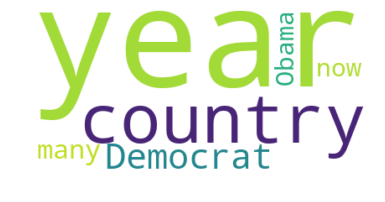

In [71]:
# Combine documents
text = " ".join( _ for _ in df.statement)
print ("There are", len(text) ,"words in the combination of all statements.")

# Generate image
wordcloud = WordCloud(min_font_size=24, 
                      max_font_size=1000, 
                      max_words=100, 
                      background_color="white").generate(text)

# Display image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [72]:
# wordcloud function for readability
def word_cloud(column):
    
    # Combine documents
    text = " ".join( _ for _ in column)
    
    # Sanity check
    print ("There are", len(text) ,"words")

    # Generate image
    plt.figure(figsize=(12, 10))
    wordcloud = WordCloud(min_font_size=5, 
                          max_font_size=60, 
                          max_words=20, 
                          background_color="white").generate(text)

    # Display the generated image
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Truth Word Clouds

There are 1788 words


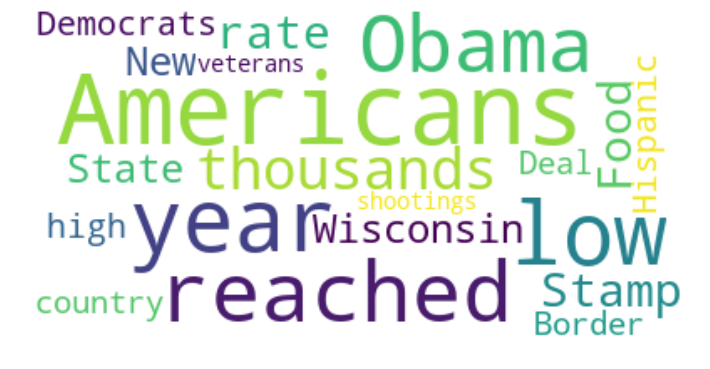

In [73]:
word_cloud(df[df.veracity == "True"].statement)

There are 1091 words


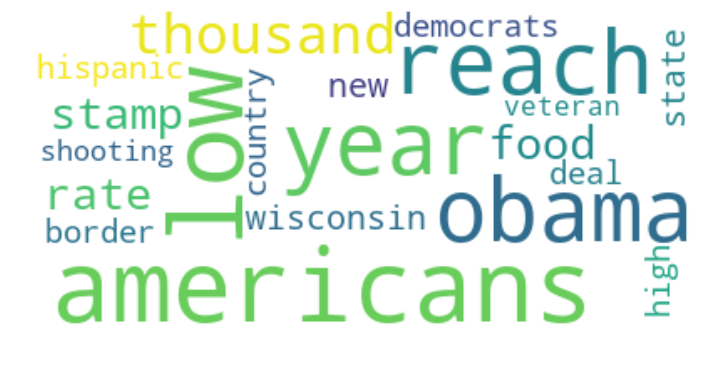

In [74]:
word_cloud(df[df.veracity == "True"].lemmas)

## Falsehood Word Clouds

There are 12936 words


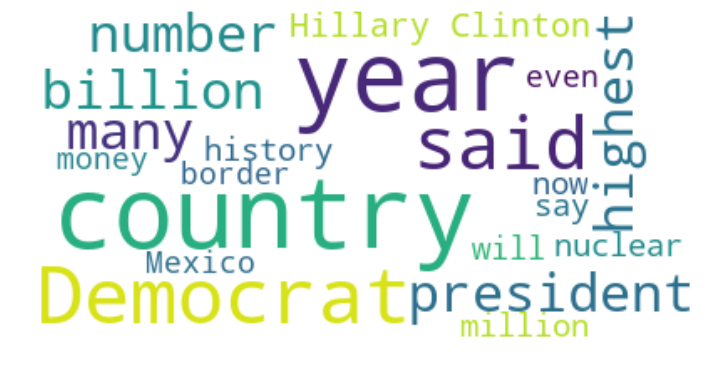

In [75]:
word_cloud(df[df.veracity == "False"].statement)

There are 6792 words


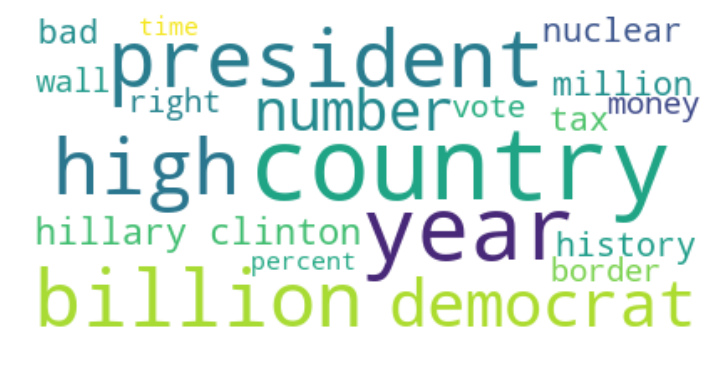

In [76]:
word_cloud(df[df.veracity == "False"].lemmas)

## Pants-on-Fire! Word Clouds

There are 4576 words


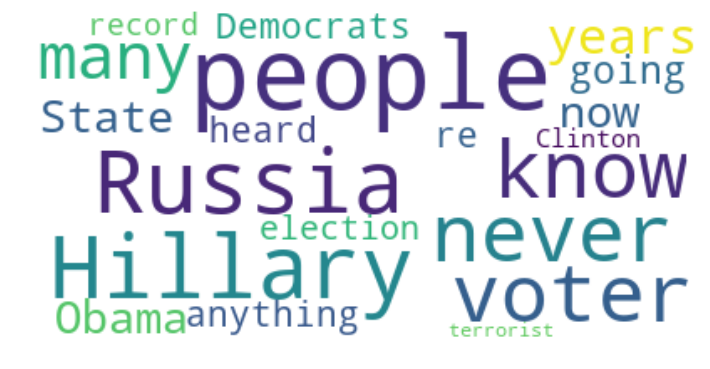

In [77]:
word_cloud(df[df.veracity == "Pants on Fire!"].statement)

There are 2243 words


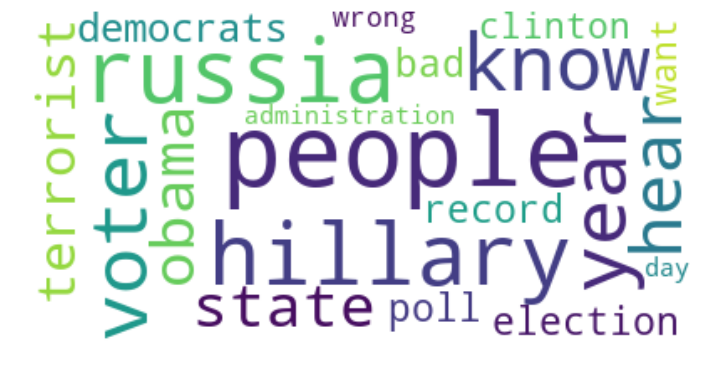

In [78]:
word_cloud(df[df.veracity == "Pants on Fire!"].lemmas)